In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
import os
from IPython.display import Image, display
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay

In [2]:
# Set Seed
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Reading Data

In [3]:
train_data = pd.read_csv("/kaggle/input/miia-pothole-image-classification-challenge/train_ids_labels.csv")
test_data = pd.read_csv("/kaggle/input/miia-pothole-image-classification-challenge/test_ids_only.csv")

In [4]:
train_data.columns

Index(['Image_ID', 'Label'], dtype='object')

In [5]:
train_data.count()

Image_ID    4026
Label       4026
dtype: int64

In [6]:
def read_data(data,size, alpha = 1.5, beta = -100, split="Training"):
    #data = data ids dataframe
    #alpha = Contrast control
    #beta = Brightness control
    x, y = [], [] 
    for i in data.values:
        img = cv2.imread(f"/kaggle/input/miia-pothole-image-classification-challenge/all_data/all_data/{i[0]}.JPG")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #adjust colors
        adjusted_img = cv2.convertScaleAbs(img_rgb, alpha=float(alpha), beta=beta)
        #crop
        cropped_img = adjusted_img[225:400 , :]
        #resize image
        resizedimg = cv2.resize(cropped_img,(size,size))
        x.append(resizedimg)
        if split=="Training":
            y.append(i[1])
        elif split=="Testing":
            y.append(i[0])
    return np.array(x) , np.array(y)

In [7]:
x_train, y_train = read_data(train_data, 224)

In [8]:
print(x_train.shape)
print(y_train.shape)

(4026, 224, 224, 3)
(4026,)


# Exploring Data

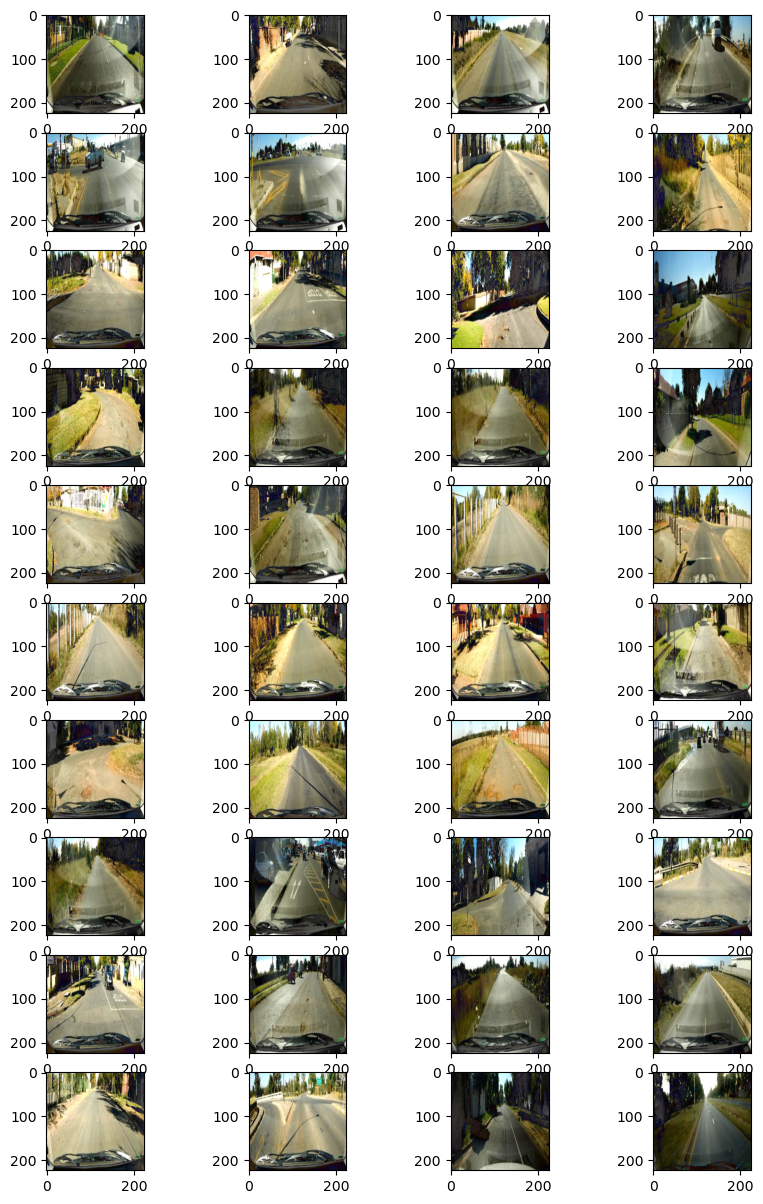

In [9]:
counter = 0
fig, axs = plt.subplots(10,4, figsize=(10, 15))
for i in range(0,4):
    for j in range(0,10):
        axs[j, i].imshow(x_train[counter])
        counter+=1

In [10]:
train_data.Label.value_counts()

0    2365
1    1661
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

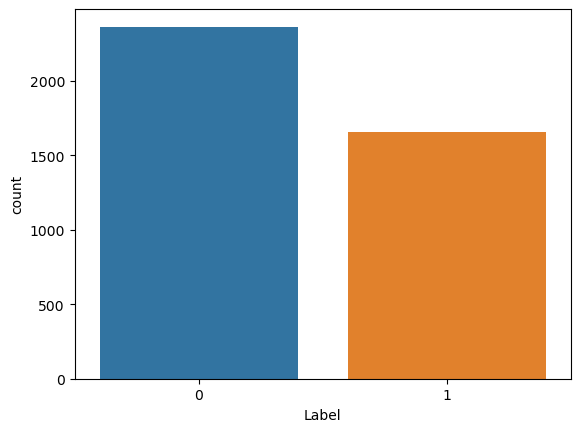

In [11]:
sns.countplot(data=train_data, x="Label")

# Xception Model

###  Data Augmentation

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                            width_shift_range=.2,
                                                            height_shift_range=.2,
                                                            shear_range=.1,
                                                            horizontal_flip=True,
                                                            fill_mode='nearest',
                                                            zoom_range=.2)

trainGen = datagen.flow(x_train, y_train,
                        batch_size = 64,
                        seed = seed,
                        shuffle = True)

gc.collect()

88

### Model Architecture  

In [13]:
xception = tf.keras.applications.Xception(input_shape=(224, 224,3), include_top=False, weights="imagenet" )
globalaverage = tf.keras.layers.GlobalAveragePooling2D()(xception.layers[-1].output)

de_1 = tf.keras.layers.Dense(128, "relu")(globalaverage)
bn_1 = tf.keras.layers.BatchNormalization()(de_1)
de_2 = tf.keras.layers.Dense(64, "relu")(bn_1)
bn_2 = tf.keras.layers.BatchNormalization()(de_2)

de_3 = tf.keras.layers.Dense(128, "relu")(bn_2)
bn_3 = tf.keras.layers.BatchNormalization()(de_3)
de_4 = tf.keras.layers.Dense(64, "relu")(bn_3)
bn_4 = tf.keras.layers.BatchNormalization()(de_4)

de_5 = tf.keras.layers.Dense(32, "relu")(bn_4)
clf = tf.keras.layers.Dense(1, "sigmoid")(de_5)

model = tf.keras.models.Model(inputs=xception.layers[0].input, outputs=clf)

In [14]:
model.compile(optimizer="rmsprop", loss=tf.keras.losses.BinaryFocalCrossentropy(),metrics=['acc'])
gc.collect()
history=model.fit(trainGen, epochs = 10, batch_size=32)
gc.collect()

Epoch 1/10
63/63 [==============================] - 83s 902ms/step - loss: 0.1320 - acc: 0.8152
Epoch 2/10
63/63 [==============================] - 57s 903ms/step - loss: 0.0818 - acc: 0.8825
Epoch 3/10
63/63 [==============================] - 57s 904ms/step - loss: 0.0603 - acc: 0.9168
Epoch 4/10
63/63 [==============================] - 58s 912ms/step - loss: 0.0450 - acc: 0.9314
Epoch 5/10
63/63 [==============================] - 56s 890ms/step - loss: 0.0403 - acc: 0.9441
Epoch 6/10
63/63 [==============================] - 57s 892ms/step - loss: 0.0323 - acc: 0.9543
Epoch 7/10
63/63 [==============================] - 57s 903ms/step - loss: 0.0277 - acc: 0.9655
Epoch 8/10
63/63 [==============================] - 58s 912ms/step - loss: 0.0216 - acc: 0.9749
Epoch 9/10
63/63 [==============================] - 58s 908ms/step - loss: 0.0262 - acc: 0.9642
Epoch 10/10
63/63 [==============================] - 57s 900ms/step - loss: 0.0193 - acc: 0.9712


0

### Model Evaluation  

In [15]:
model.evaluate(x_train, y_train)

126/126 [==============================] - 11s 78ms/step - loss: 0.0103 - acc: 0.9881


[0.01031282264739275, 0.9880775213241577]

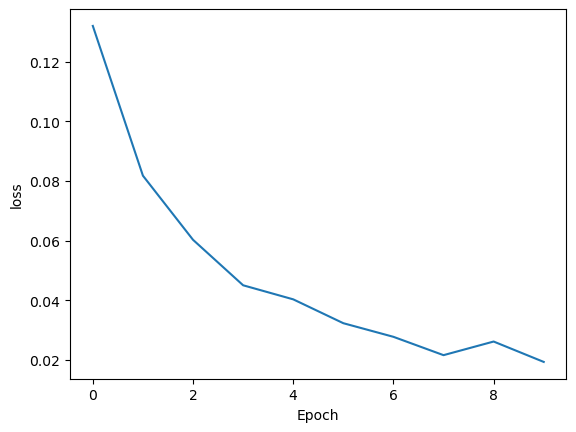

In [16]:
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  no pothole       1.00      0.98      0.99      2365
     pothole       0.98      0.99      0.99      1661

    accuracy                           0.99      4026
   macro avg       0.99      0.99      0.99      4026
weighted avg       0.99      0.99      0.99      4026



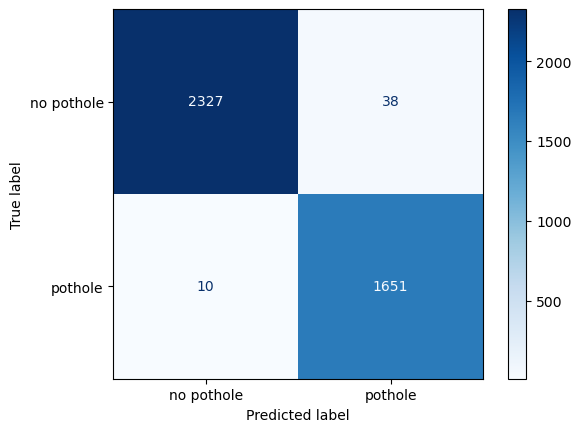

In [17]:
y_output = (model.predict(x_train, verbose = 0)).round()
print('Confusion Matrix')
cm = confusion_matrix(y_train, y_output)
print('Classification Report')
target_names = ['no pothole','pothole']
print(classification_report(y_train, y_output, target_names=target_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Submission file 

In [18]:
x_test, images_id = read_data(test_data, 224, split="Testing")

In [19]:
predictions = [model.predict(i.reshape(1,224,224,3), verbose=0)[0][0] for i in x_test]

In [20]:
dic = {
    "Image_ID": images_id,
    "Label": predictions
}

submission = pd.DataFrame(dic)

In [21]:
submission.to_csv('./submission.csv', index=False)
gc.collect()

25128

### GRAD-CAM interpretation

In [22]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )
    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

def superimpose_gradcam(img, heatmap, output_path="grad_cam_image.jpg", alpha=0.5):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)
    return superimposed_img
    #display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
def GRAD_CAM(img, model, last_conv_layer = "block14_sepconv2_act"):
    fig, ax = plt.subplots(1,2)
    ax[0].matshow(get_heatmap(img.reshape(1,224,224,3), model, last_conv_layer))
    ax[1].imshow(superimpose_gradcam(img, get_heatmap(img.reshape(1,224,224,3), model, last_conv_layer)))
    plt.show()

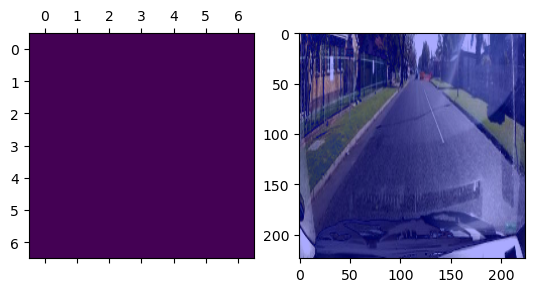

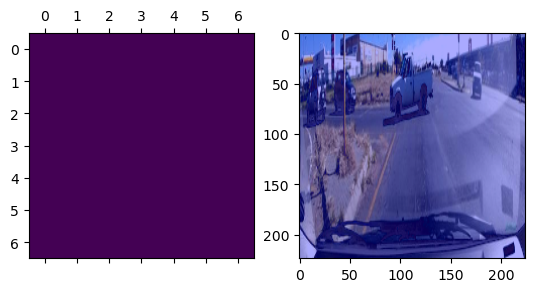

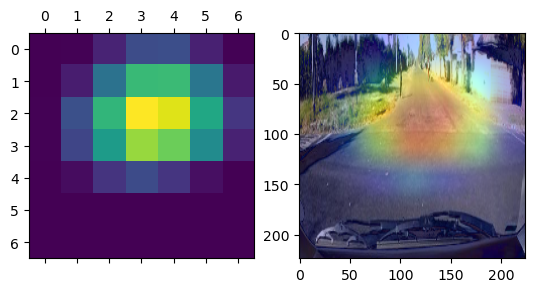

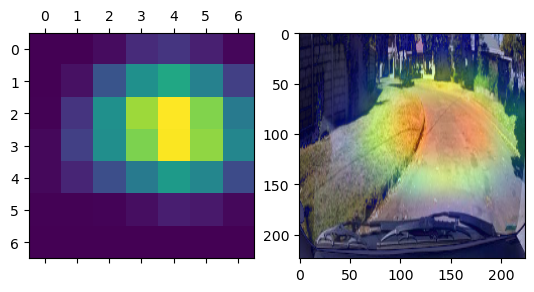

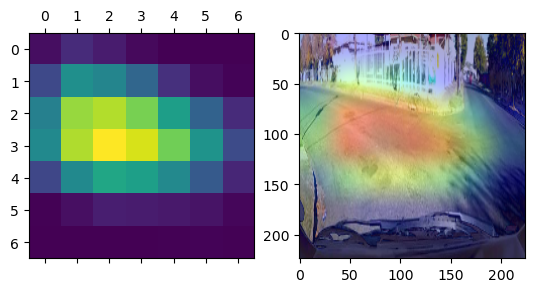

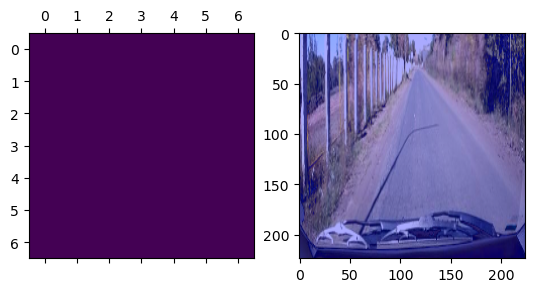

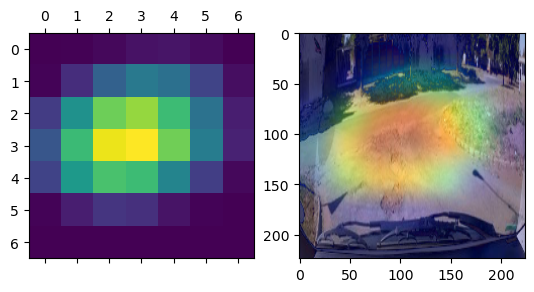

In [25]:
for i in range (7):
    GRAD_CAM(x_train[i], model)